In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image
from PIL.ImageDraw import Draw

In [2]:
width = 480
height = 480

num_classes = 2
classes = ["sign", "no-sign"]

In [3]:
TRAINING_CSV_FILE = 'Data/training_data.csv'
VALIDATION_CSV_FILE = 'Data/validation_data.csv'
TRAINING_IMAGE_DIR = 'Images/training'
VALIDATION_IMAGE_DIR = 'Images/validation'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)
validation_image_records = pd.read_csv(VALIDATION_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)
validation_image_path = os.path.join(os.getcwd(), VALIDATION_IMAGE_DIR)

train_images = []
train_targets = []

for index, row in training_image_records.iterrows():

    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)


    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)

    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))



validation_images = []
validation_targets = []

for index, row in validation_image_records.iterrows():

    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    validation_image_fullpath = os.path.join(validation_image_path, filename)
    validation_img = keras.preprocessing.image.load_img(validation_image_fullpath, target_size=(height, width))
    validation_img_arr = keras.preprocessing.image.img_to_array(validation_img)

    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)

    validation_images.append(validation_img_arr)
    validation_targets.append((xmin, ymin, xmax, ymax))

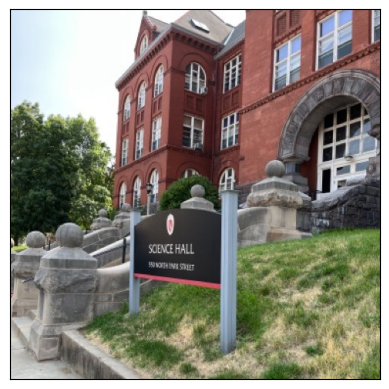

In [4]:
  fig = plt.imshow(train_images[0].astype('uint8'))
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)

In [5]:
#create the common input layer
input_shape = (480, 480, 3)
input_layer = tf.keras.layers.Input(input_shape)

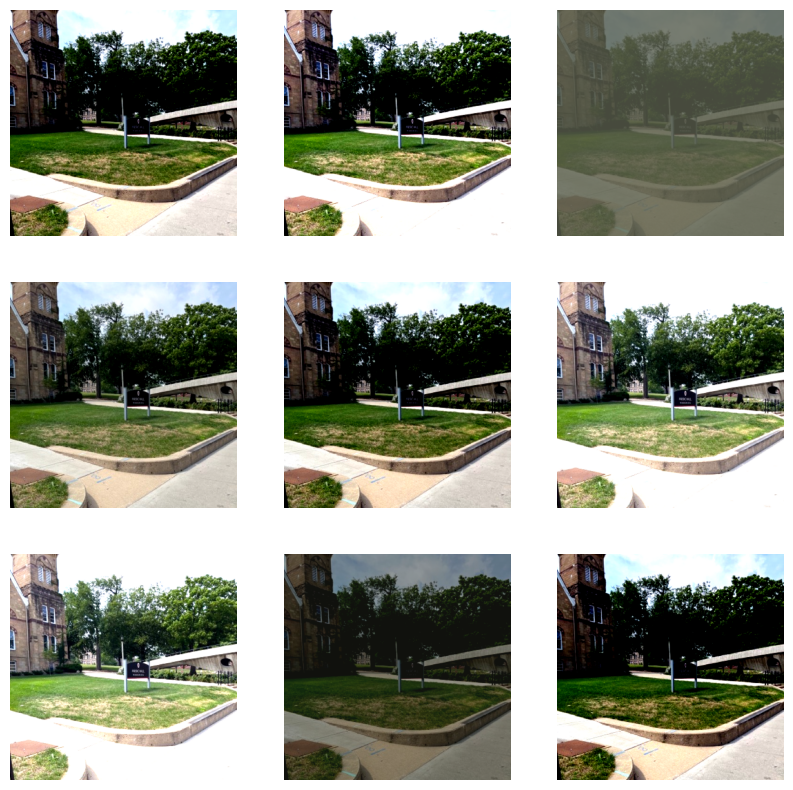

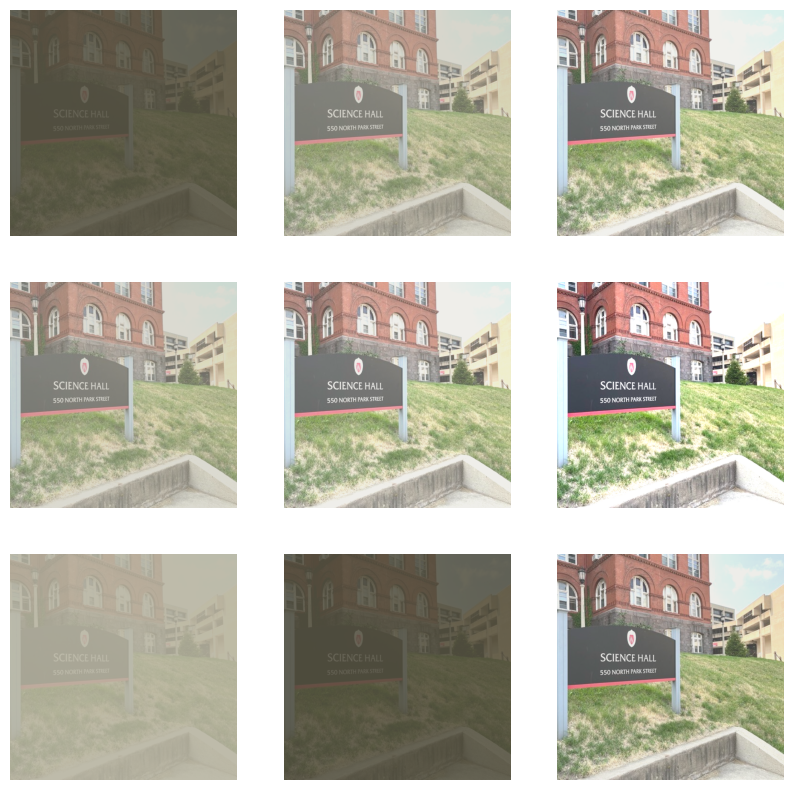

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomBrightness(
    0.3, value_range=(0, 255), seed=7),
  tf.keras.layers.RandomContrast((0.99,1.01),seed=7)
])

for image in train_images[1:3]:
  plt.figure(figsize=(10, 10))
  first_image = image
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [9]:
x = data_augmentation(input_layer)
x = tf.keras.layers.Resizing(224, 224, interpolation='lanczos3', crop_to_aspect_ratio=False)(x)

x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = base_model(x, training=False)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = global_average_layer(x)

locator_branch = layers.Dense(128, activation='relu', name='bb_1')(x)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)
model = tf.keras.Model(input_layer, outputs=[locator_branch])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 480, 480, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [11]:
losses = {"bb_head":tf.keras.losses.MSE}


In [12]:
base_learning_rate = 0.01
model.compile(loss=losses, optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy'])

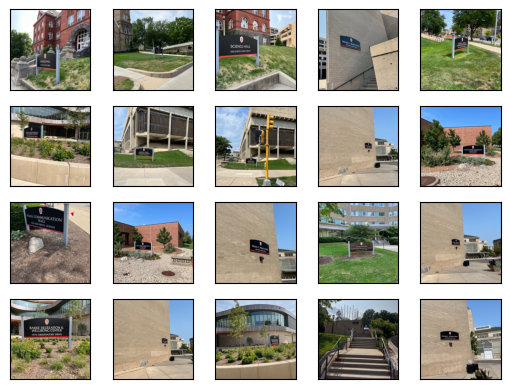

In [13]:
training_epochs = 50

train_images = np.array(train_images)
train_targets = np.array(train_targets)


validation_images = np.array(validation_images)
validation_targets = np.array(validation_targets)


# show some images
for i in range(20):
  plt.subplot(4,5,i+1)
  fig = plt.imshow(train_images[i].astype('uint8'))
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)

In [14]:
trainTargets = {
    "bb_head": train_targets
}

validationTargets = {
    "bb_head": validation_targets
}

In [15]:
print(type(trainTargets))

<class 'dict'>


In [16]:
initial_epochs = 10

history = model.fit(train_images, trainTargets,
                   validation_data=(validation_images, validationTargets),
                   batch_size=10,
                   epochs=initial_epochs,)

Epoch 1/10
10/10 [==============================] - 3s 163ms/step - loss: 0.1575 - accuracy: 0.4400 - val_loss: 0.1746 - val_accuracy: 0.5854
Epoch 2/10
10/10 [==============================] - 1s 112ms/step - loss: 0.1757 - accuracy: 0.6400 - val_loss: 0.1746 - val_accuracy: 0.5854
Epoch 3/10
10/10 [==============================] - 1s 135ms/step - loss: 0.1757 - accuracy: 0.6400 - val_loss: 0.1746 - val_accuracy: 0.5854
Epoch 4/10
10/10 [==============================] - 1s 120ms/step - loss: 0.1757 - accuracy: 0.6400 - val_loss: 0.1746 - val_accuracy: 0.5854
Epoch 5/10
10/10 [==============================] - 1s 116ms/step - loss: 0.1757 - accuracy: 0.6400 - val_loss: 0.1746 - val_accuracy: 0.5854
Epoch 6/10
10/10 [==============================] - 1s 115ms/step - loss: 0.1757 - accuracy: 0.6400 - val_loss: 0.1746 - val_accuracy: 0.5854
Epoch 7/10
10/10 [==============================] - 1s 110ms/step - loss: 0.1757 - accuracy: 0.6400 - val_loss: 0.1746 - val_accuracy: 0.5854
Epoch 

In [17]:
base_model.trainable = True

In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 144

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [19]:
base_learning_rate = 0.01
model.compile(loss=losses, optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=['accuracy'])

In [20]:
checkpoint_filepath = '/content/drive/My Drive/539FinalProject/checkpoint'
#es_callback = keras.callbacks.EarlyStopping(monitor="val_bb_head_accuracy", min_delta=0, patience=7,verbose=1,mode="max",baseline=0,start_from_epoch=5)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_bb_head_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_images, trainTargets,
                   validation_data=(validation_images, validationTargets),
                   batch_size=10,
                   epochs=40,
                   shuffle=True,
                   verbose=1,
                   callbacks=[model_checkpoint_callback])
                   #es_callback，
model.load_weights(checkpoint_filepath)

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.6400

PermissionDeniedError: /content; Read-only file system

In [ ]:


bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']



bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']



epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()


In [ ]:
test_dir = pathlib.Path('/content/drive/My Drive/539FinalProject/Images/test')
img_paths = list(test_dir.glob('*.jpg'))


plt.figure(figsize=(20, 20))

for i, img_path in enumerate(img_paths):
    test_img = keras.preprocessing.image.load_img(img_path, target_size=(height, width))
    img_arr = keras.preprocessing.image.img_to_array(test_img)
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)

    score = tf.nn.softmax(predictions[0][0])

    percent = int(round(100*np.max(score), 0))
    class_name = classes[np.argmax(score)]
    title = "{} - {} %".format(class_name, percent)
    #print(i)

    bbox = predictions[1][0]
    bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]

    draw1 = Draw(test_img)
    draw1.rectangle(bbox, outline='yellow', width=2)
        #test_img

    ax = plt.subplot(6, 5, i+1)
    plt.imshow(test_img)
    plt.axis("off")


In [ ]:
model.save('./Saved-Models/Locator')

In [ ]:
for layer in model.layers:
    if layer.name.startswith('bl_'):
        print(layer.name)
        layer.trainable = False

for layer in model.layers:
    if layer.name.startswith('bb_'):
        print(layer.name)
        layer.trainable = False